# When Computers Cry: Predicting Tearjerker Anime Using Scikit-learn

One of the few pieces of media to have ever coaxed tears from me is Kyoto Animation's devastating 2008 anime series *Clannad: After Story*, a show that I enthusiatically recommend. And I do so not in spite of the fact that it crushed my soul but because of it. If anything, I consider an anime's ability to turn on the waterworks to be a marker of quality. Most of my favorite anime are considered tearjerkers, *A Place Further than the Universe*, *Your Name*, and *K-On* come to mind as notable examples. Even if I don't tear up while watching them, a decent attempt made by an anime's creators still gets enormous credit from me. Given my interest in anime, I decided to take on the task of predicting tearjerker anime as a starter project for me to clarify and advance my understanding of machine learning and Scikit-learn.

Using data scraped off of the website MyAnimeList courtesy of , here's what I did . . .

1. Determined for anime whether each is a tearjerker or not based on the frequency of key words, "cry", "tears," etc., in their reviews.
2. Used the synopsis of the anime from MyAnimeList along with to predict 

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
# https://pub.towardsai.net/emoticon-and-emoji-in-text-mining-7392c49f596a
# https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7
from emot.emo_unicode import EMOTICONS_EMO, EMOJI_UNICODE
# https://www.kaggle.com/code/shsagar/finding-anime-genre-based-on-synopsis-logistic-reg
import nltk
from nltk.corpus import stopwords

# Wrangle Anime Data

In [2]:
# Load data
# https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews?select=animes.csv
animes = pd.read_csv("data/animes.csv") 
# https://www.kaggle.com/datasets/azathoth42/myanimelist?select=AnimeList.csv
AnimeList = pd.read_csv("data/AnimeList.csv")

In [3]:
AnimeList = AnimeList[["anime_id", 
                       "title_english", 
                       "title_synonyms", 
                       "type", 
                       "source", 
                       "producer", 
                       "licensor", 
                       "studio"]]
animes = animes.merge(AnimeList, how = "left", left_on = "uid", right_on = "anime_id")
anime = animes[["uid", 
                "title", 
                "title_english", 
                "title_synonyms",
                "score",
                "members",
                "type",
                "episodes",
                "synopsis", 
                "genre", 
                "source", 
                "studio",
                "producer", 
                "licensor"]]
anime = anime.drop_duplicates()
anime.head()

,uid,title,title_english,title_synonyms,score,members,type,episodes,synopsis,genre,source,studio,producer,licensor
0,28891,Haikyuu!! Second Season,Haikyu!! 2nd Season,Haikyuu!! Second Season,8.82,489888,TV,25.0,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",Manga,Production I.G,"TOHO animation, Shueisha",Sentai Filmworks
1,23273,Shigatsu wa Kimi no Uso,Your Lie in April,NaN,8.83,995473,TV,22.0,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",Manga,A-1 Pictures,"Aniplex, Dentsu, Kodansha, Fuji TV, Kyoraku In...",Aniplex of America
2,34599,Made in Abyss,Made in Abyss,NaN,8.83,581663,TV,13.0,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",Web manga,Kinema Citrus,"Media Factory, AT-X, Takeshobo, Sony Music Com...",Sentai Filmworks
3,5114,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",9.23,1615084,TV,64.0,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",Manga,Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America"
4,31758,Kizumonogatari III: Reiketsu-hen,NaN,"Koyomi Vamp, Kizumonogatari Part 3",8.83,214621,Movie,1.0,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",Light novel,Shaft,"Aniplex, Kodansha",NaN


# What is a tearjerker anime?

In order to predict tearjerker anime, I must define it. To construct this target vector, I used a dataset of anime reviews. Thus, the determination of whether an anime is a tearjerker or not is based upon reviewers' reactions.

In [ ]:
# reviews = pd.read_csv("data/reviews.csv")
# reviews = reviews.drop_duplicates()

In [ ]:
# import math

# total_rows = len(reviews)
# max_rows = 10000
# num_files = math.ceil(total_rows/max_rows)

# start = 0
# end = 9999

# for i in range(1, num_files + 1):
#     i = str(i)
#     print("Writing file #" + i)
#     reviews.iloc[start:(end + 1), :].to_csv("data/reviews/reviews" + i + ".csv", index = False)
#     start += 10000
#     end += 10000

In [ ]:
# Read in data
reviews = pd.read_csv("data/reviews/reviews1.csv")
for i in range(2, 15):
    i = str(i)
    print(f"Concatenating data file #{i}")
    addition = pd.read_csv(f"data/reviews/reviews{i}.csv")
    reviews = pd.concat([reviews, addition])

In [ ]:
# Keep only relevant fields
reviews = reviews[["uid", "anime_uid", "link", "text"]]

In [ ]:
review_counts = reviews.groupby("anime_uid")["anime_uid"].count() 
keep_anime = review_counts[review_counts >= 10].index.tolist()
reviews = reviews[reviews["anime_uid"].isin(keep_anime)]
reviews = reviews.reset_index(drop = True)

In [ ]:
# n = reviews.groupby("anime_uid")["uid"].nunique().rename("n")
# reviews = reviews.sort_values(["anime_uid", "uid"]).groupby("anime_uid").head(1)
# reviews = reviews.merge(n, how = "left", left_on = "anime_uid", right_index = True)

## Remove front and back matter

In [ ]:
filler = re.compile(r"^[\s\w]*Enjoyment[\s\d]*|\s*Helpful\s*$") # Assumes reviews never start with a number
reviews["text"] = reviews["text"].str.replace(filler, "")

## Replace emoticons

The reviews feature heavy use of emoticons. These symbols allow users to succintly communicate an emotional reaction through pictograms comprised of punctuation, letters, numbers, etc. Because they convey information on emotion, I want to retain them to help me determine whether an anime is a tearjerker or not. However, since they include punctuation, which will be removed from the text later on in the process of constructing the target vector, I opted to replace them with verbal descriptions.

I used a dictionary of emoticons from the `emot` library ...

In [ ]:
# http://introtopython.org/dictionaries.html#General-Syntax
emoticons = {}
for symbol, meaning in EMOTICONS_EMO.items():
    emoticons[symbol] = "".join([word.capitalize() for word in meaning.replace(",", "").split()])

... and added a few missing emoticons.

In [ ]:
emoticons["(^—^)"] = "NormalLaugh"
emoticons["-_-“"] = "Troubled" 
emoticons[":s)"] = "HappyFaceOrSmiley" 
emoticons[":S)"] = "HappyFaceOrSmiley" 
# https://en.wikipedia.org/wiki/List_of_emoticons
emoticons[">W<"] = "Troubled"
emoticons["-_-'"] = "Troubled"
# https://www.urbandictionary.com/define.php?term=%3E_%3E
emoticons[">_>"] = "RightSidewaysLook"
emoticons["<_<"] = "LeftSidewaysLook"

Since many long emoticons are simply short ones with additional characters, I sorted the emoticons in descending order according to their length so that, later on, the longer emoticons would be matched prior to shorter emoticons. 

In [ ]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
# https://www.w3schools.com/python/ref_func_sorted.asp
emoticons = dict(sorted(emoticons.items(), key = lambda item: -len(item[0])))

I then assembled a list of emoticons that feature in both the dictionary and the reviews. I managed to get 97 unique emoticons, but I'm sure I missed some T_T.

In [ ]:
# https://www.pythonforbeginners.com/basics/list-comprehensions-in-python
# https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
# https://stackoverflow.com/questions/4202538/escape-special-characters-in-a-python-string
pattern = "\s(" + "|".join([re.escape(emoticon) for emoticon in emoticons]) + ")\W?"
used_emoticons = reviews["text"].str.extractall(pattern)

Here, I'm converting the dataframe of used emoticons into a dictionary.

In [ ]:
# https://www.digitalocean.com/community/tutorials/python-convert-numpy-array-to-list
used_emoticons = used_emoticons.dropna().drop_duplicates().iloc[:, 0].tolist()
# https://stackoverflow.com/questions/5352546/extract-subset-of-key-value-pairs-from-dictionary
used_emoticons = {symbol: emoticons[symbol] for symbol in used_emoticons}

Again, I'm sorting the emoticons according to their length.

In [ ]:
used_emoticons = dict(sorted(used_emoticons.items(), key = lambda item: -len(item[0])))

Now, I'm looping through each emoticon and replacing it with its respective value in the dictionary if it's preceded by a white space and followed by a non-word character. These conditions are meant to reduce the likelihood of false-positives.

In [ ]:
for symbol, meaning in used_emoticons.items():
    print(f"Replacing {symbol} with {meaning}")
    reviews["text"] = reviews["text"].str.replace("(?<=\s)" + re.escape(symbol) + "(?=\W?)", meaning, regex = True)

In [ ]:
reviews.to_csv("data/intermediates/replace_emoticons.csv", index = False)
reviews = pd.read_csv("data/intermediates/replace_emoticons.csv")

## Drop titles

I use the appearance of key words such as "cry" and "tears" in user reviews to determine whether an anime is a tearjerker or not. Some anime include these key words in their titles, meaning users really can't help but mention them in their reviews. Thus, to ensure that I'll only be counting authentic appearances of these terms, I exclude the title of the anime being discussed from the text of each review.

*True Tears* is a peculiar case because one of its characters' ability to cry is a central plot point. Thus, reviewers who are summarizing its story mention crying quite a lot even after scrubbing its reviews of any mention of the title.

In [ ]:
reviews = reviews.merge(
    anime[["uid", "title", "title_english", "title_synonyms"]], 
    how = "left", left_on = "anime_uid", right_on = "uid"
)
reviews = reviews.drop(columns = "uid_y").rename(columns = {"uid_x": "uid"})
reviews["text"] = reviews["text"].str.lower()
reviews["title"] = reviews["title"].str.lower()
reviews["title_english"] = reviews["title_english"].str.lower()
reviews["title_synonyms"] = reviews["title_synonyms"].str.lower()

In [ ]:
for field in ["title", "title_english", "title_synonyms"]:
    for i in range(len(reviews)):
        print(f"Processing row #{str(i)} for {field}")
        title = reviews[field].iloc[i]
        if not pd.isna(title):
            unigrams = reviews[field].iloc[[i]].str.split().iloc[0]
            # http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
            bigrams = [" ".join(unigram) for unigram in list(zip(unigrams, unigrams[1:]))]
            pattern = "|".join([re.escape(title)] + [re.escape(bigram) for bigram in bigrams])
            reviews["text"].iloc[[i]] = reviews["text"].iloc[[i]].str.replace(pattern, "", regex = True)

In [ ]:
reviews = reviews.drop(columns = ["title", "title_english", "title_synonyms"])
reviews.to_csv("data/intermediates/drop_titles.csv", index = False)
reviews = pd.read_csv("data/intermediates/drop_titles.csv")

## Tokenize text

I turn the table of reviews where each row is one review into a table of tokens where each row is one token from a review.

In [ ]:
reviews["text"] = reviews["text"].str.strip()
reviews["text"] = reviews["text"].str.replace("\\", " ", regex = True)
reviews["text"] = reviews["text"].str.replace("/", " ")                                      
reviews["text"] = reviews["text"].str.replace("‘", "'").str.replace("’", "'")
reviews["text"] = reviews["text"].str.replace("“", '"').str.replace("”", '"')
# "–" is used as punctuation while "-" is used to create phrases
pattern = "[" + string.punctuation.replace("'", "").replace("-", "") + "–" + "…" + "]" 
pattern = pattern + r"|(?<=\s)'(?=\w)|(?<=\w)'(?=\s)"
reviews["text"] = reviews["text"].str.replace(pattern, "", regex = True)

In [ ]:
reviews["text"] = reviews["text"].str.split()
reviews = reviews.explode("text")

In [ ]:
reviews.to_csv("data/intermediates/tokenize_text.csv", index = False)
reviews = pd.read_csv("data/intermediates/tokenize_text.csv", na_filter = False)

## Replace non-word characters except for emojis and select punctuation

To further cleanse the tokens, I want to drop all non-word characters that aren't emojis. For the same reason as emoticons, I want to use emojis to create my target vector because they convey emotional information. First, I create a list of the unique non-word characters present in the reviews.

In [ ]:
unique_tokens = reviews["text"].drop_duplicates()
non_word = unique_tokens.str.extractall(r"(\W)").drop_duplicates()
non_word = non_word.iloc[:, 0].tolist()

Next, I reformat the definitions from the emoji dictionary that I obtained from the `emot` library.

In [ ]:
emojis = {}
for meaning, symbol in EMOJI_UNICODE.items():
    emojis[symbol] = meaning 

I also create a regex pattern that separates all the characters that I want to drop by a pipe, `|`.

In [ ]:
# https://stackoverflow.com/questions/51976328/best-way-to-remove-xad-in-python
# https://stackoverflow.com/questions/31522361/python-getting-rid-of-u200b-from-a-string-using-regular-expressions
# https://stackoverflow.com/questions/17912307/u-ufeff-in-python-string
drop = [char for char in non_word if char not in emojis]
drop.remove("'")
drop.remove("-")
drop = "|".join(drop) # Create regex pattern

Using the pattern created above, I replace the specified non-word characters with empty strings. I drop these empty strings along with tokens that are comprised of consecutive hyphens. These tokens are used by reviewers as horizontal lines to format their pieces. However, I have no use for them.

In [ ]:
reviews["text"] = reviews["text"].str.replace(drop, "", regex = True)
reviews = reviews[(reviews["text"] != "") & ~(reviews["text"].str.fullmatch(r"(-+)"))]

## Remove stopwords

I drop the rows of the table that belonged to stop words.

In [4]:
nltk.download("stopwords")
stopwords = list(stopwords.words("English"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peiyizhuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
reviews = reviews[~reviews["text"].isin(stopwords)]

In [5]:
# reviews.to_csv("data/intermediates/cleaned_text.csv", index = False)
reviews = pd.read_csv("data/intermediates/cleaned_text.csv")

## Add target field

Here I define what I mean by a "tearjerker" anime. An anime is considered a tearjerker if its reviews feature at least one word from the `sad_words` list in addition to at least one from `cry_words`. This dual criteria serves as an indicator of whether an anime prompted its audience to weap from sadness.

In [6]:
sad_words = ["sad",
             "saddest",
             "emotion",
             "emotions",
             "emotional",
             "emotionally",
             "depressed",
             "depressing",
             "depressingly",
             "tragic",
             "tragedy",
             "sentimental"]

cry_words = ["cry", 
             "cried", 
             "crying", 
             "sob", 
             "sobbed", 
             "sobbing", 
             "bawl", 
             "bawled", 
             "bawling", 
             "tear", 
             "tears", 
             "teared", 
             "tearing", # as in "tearing up"
             "sadorcrying",
             "tearsofhappiness",
             "sadofcrying",
             "😭"]

reviews["sad"] = reviews["text"].isin(sad_words)
reviews["cry"] = reviews["text"].isin(cry_words)

In [17]:
cry_vote = reviews.groupby(["anime_uid", "uid"]).agg(
    sad = pd.NamedAgg(column = "sad", aggfunc = "sum"),
    cry = pd.NamedAgg(column = "cry", aggfunc = "sum")
)
cry_vote["cry"] = (cry_vote["sad"] > 0) & (cry_vote["cry"] > 0)
cry_vote = cry_vote["cry"].reset_index()
cry_vote = cry_vote.groupby("anime_uid").agg(
    cry = pd.NamedAgg(column = "cry", aggfunc = "mean"),
    n = pd.NamedAgg(column = "uid", aggfunc = "nunique")
)
cry_vote = cry_vote.reset_index()

In [ ]:
# cry_vote = reviews.groupby("anime_uid").agg(
#     cry = pd.NamedAgg(column = "cry", aggfunc = "sum"),
#     n = pd.NamedAgg(column = "n", aggfunc = "mean")
# )
# cry_vote = cry_vote.reset_index()
# cry_vote["cry"] = cry_vote["cry"] > 0

In [19]:
anime = cry_vote.merge(anime, how = "left", left_on = "anime_uid", right_on = "uid").drop(columns = "anime_uid")

In [21]:
anime.to_csv("data/intermediates/anime.csv", index = False)
anime = pd.read_csv("data/intermediates/anime.csv")

# Create test set

In [22]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(anime, test_size = 0.2, random_state = 500)

In [78]:
# train_set.to_csv("data/intermediates/train.csv", index = False)
train_set = pd.read_csv("data/intermediates/train.csv")

# EDA

In [79]:
train_set.head()

,cry,n,uid,title,title_english,title_synonyms,score,members,type,episodes,synopsis,genre,source,studio,producer,licensor
0,0.000000,20,32271,Dies Irae,Dies irae,Day of Wrath,5.46,97796,TV,11.0,"On May 1, 1945 in Berlin, as the Red Army rais...","['Action', 'Military', 'Super Power', 'Magic']",Visual novel,A.C.G.T.,"Genco, DMM pictures, Greenwood, My Theater D.D...",Funimation
1,0.088889,45,856,Utawarerumono,Utawarerumono,The One Being Sung,7.71,126612,TV,26.0,An injured man is found in the woods by a girl...,"['Action', 'Drama', 'Fantasy', 'Sci-Fi']",Visual novel,OLM,"Lantis, Half H.P Studio, AQUAPLUS","ADV Films, Funimation"
2,0.000000,20,17821,Stella Jogakuin Koutou-ka C³-bu,"Stella Women&#039;s Academy, High School Divis...","Stella Jogakuin Koutouka C3-bu, Stella Jogakui...",6.57,46285,TV,13.0,Yura Yamato has just arrived at the high schoo...,"['Military', 'School', 'Sports']",Manga,Gainax,"Pony Canyon, TBS, RAY",Sentai Filmworks
3,0.000000,14,2969,Appleseed Saga Ex Machina,Appleseed: Ex Machina,"Appleseed 2, Appleseed 2007",7.41,33606,Movie,1.0,"Deunan, a young female warrior, and Briareos, ...","['Action', 'Mecha', 'Military', 'Sci-Fi']",Unknown,Digital Frontier,Sega,"ADV Films, Warner Bros."
4,0.000000,30,257,Ikkitousen,Ikki Tousen,"Ikki-Tosen: Legendary Fighter, Battle Vixens",6.53,118837,TV,13.0,"In Ikkitousen , the Kanto region of Japan is ...","['Ecchi', 'Super Power', 'Martial Arts', 'Scho...",Manga,J.C.Staff,"Genco, Cosmic Ray, Eye Move, Bushiroad","Funimation, Geneon Entertainment USA"


In [80]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cry             1836 non-null   float64
 1   n               1836 non-null   int64  
 2   uid             1836 non-null   int64  
 3   title           1836 non-null   object 
 4   title_english   1340 non-null   object 
 5   title_synonyms  1215 non-null   object 
 6   score           1836 non-null   float64
 7   members         1836 non-null   int64  
 8   type            1762 non-null   object 
 9   episodes        1833 non-null   float64
 10  synopsis        1835 non-null   object 
 11  genre           1836 non-null   object 
 12  source          1762 non-null   object 
 13  studio          1694 non-null   object 
 14  producer        1513 non-null   object 
 15  licensor        1254 non-null   object 
dtypes: float64(3), int64(3), object(10)
memory usage: 229.6+ KB


In [81]:
train_set["cry"] = train_set["cry"] > 0

In [82]:
print(f"Proportion of tearjerker anime: {(train_set['cry']).mean()}")

Proportion of tearjerker anime: 0.5065359477124183


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9b7ef0d5e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b7ef0dca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9b7ef0d280>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9b7ef193a0>,
 'fliers': [],
 'means': []}

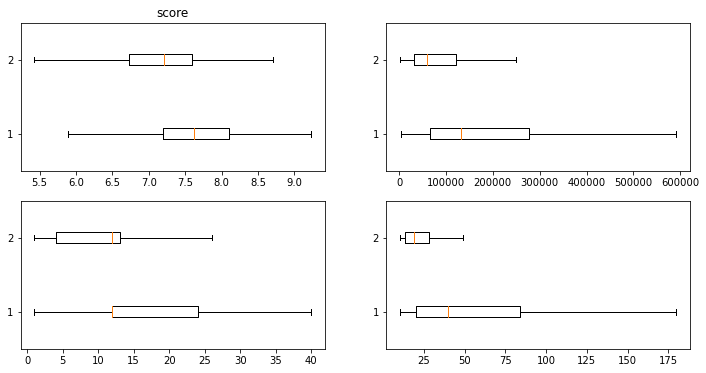

In [83]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 2, 1)
cry_score = train_set[train_set["cry"]]["score"].dropna()
no_cry_score = train_set[~train_set["cry"]]["score"].dropna()
plt.boxplot([cry_score, no_cry_score], vert = False, showfliers = False)
plt.title("score")

plt.subplot(2, 2, 2)
cry_members = train_set[train_set["cry"]]["members"]
no_cry_members = train_set[~train_set["cry"]]["members"]
plt.boxplot([cry_members, no_cry_members], vert = False, showfliers = False)

plt.subplot(2, 2, 3)
cry_episodes = train_set[train_set["cry"]]["episodes"].dropna()
no_cry_episodes = train_set[~train_set["cry"]]["episodes"].dropna()
plt.boxplot([cry_episodes, no_cry_episodes], vert = False, showfliers = False)

plt.subplot(2, 2, 4)
cry_reviewers = train_set[train_set["cry"]]["n"]
no_cry_reviewers = train_set[~train_set["cry"]]["n"]
plt.boxplot([cry_reviewers, no_cry_reviewers], vert = False, showfliers = False)

# Model training

In [ ]:
# anime = anime[anime["title"] != "True Tears"]

In [33]:
train_set = train_set[["cry", "score", "members", "synopsis", "genre"]]

## Drop anime with missing values 

In [34]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cry       1836 non-null   bool   
 1   score     1836 non-null   float64
 2   members   1836 non-null   int64  
 3   synopsis  1835 non-null   object 
 4   genre     1836 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 59.3+ KB


In [35]:
train_set = train_set.dropna().reset_index(drop = True)

In [65]:
y_train = train_set["cry"]
X_train = train_set[["score", "members", "synopsis", "genre"]]

## Clean `genre` and `studio` for `CountVectorizer`

In [66]:
X_train["genre"] = X_train["genre"].str.replace("[\[\]']", "", regex = True).str.split(", ")
X_train["genre"] = X_train["genre"].apply(lambda genres: [genre.replace(" ", "") for genre in genres])
X_train["genre"] = X_train["genre"].apply(lambda genres: " ".join(genres))

<ipython-input-66-eab3bee462ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["genre"] = X_train["genre"].str.replace("[\[\]']", "", regex = True).str.split(", ")
<ipython-input-66-eab3bee462ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["genre"] = X_train["genre"].apply(lambda genres: [genre.replace(" ", "") for genre in genres])
<ipython-input-66-eab3bee462ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [67]:
# anime["studio"] = anime["studio"].str.split(", ")
# anime["studio"] = anime["studio"].apply(lambda studios: [studio.replace(" ", "") for studio in studios])
# anime["studio"] = anime["studio"].apply(lambda studios: " ".join(studios))

## Clean `synopsis`

In [68]:
filler = re.compile(r"(?<=\n)[^\n]*$")
has_filler = X_train["synopsis"].str.extractall("(.)$").iloc[:, 0].str.match("[\]\)]").reset_index(drop = True)
X_train["synopsis"][has_filler] = X_train["synopsis"][has_filler].str.replace(filler, "").str.strip()

<ipython-input-68-d98ab17dd08c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["synopsis"][has_filler] = X_train["synopsis"][has_filler].str.replace(filler, "").str.strip()
/Users/peiyizhuo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


# Data transformation pipeline

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

pipeline = ColumnTransformer([
    ("Normalize score", StandardScaler(), ["score"])
    , ("Normalize members", StandardScaler(), ["members"])
#     , ("Normalize episodes", StandardScaler(), ["episodes"])
    # https://stackoverflow.com/questions/65242617/sklearn-pipeline-with-countvectorizer-and-category-on-a-pandas-dataframe
    # https://stackoverflow.com/questions/58772181/columntransformer-fails-with-countvectorizer-in-a-pipeline
#     , ("Extract features from synopsis", CountVectorizer(stop_words = stopwords), "synopsis")
    , ("Extract features from genre", CountVectorizer(stop_words = stopwords), "genre")
#     , ("Extract features from studio", CountVectorizer(stop_words = stopwords), "studio")
#     , ("One-hot encode type", OneHotEncoder(), ["type"])
])

In [70]:
# https://stackoverflow.com/questions/23838056/what-is-the-difference-between-transform-and-fit-transform-in-sklearn
X_train = pipeline.fit_transform(X_train)

# Fit logistic regression model

In [71]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [72]:
from sklearn.model_selection import cross_val_score
# model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train)

array([0.67574932, 0.66757493, 0.69209809, 0.71662125, 0.71117166])

# Evaluate logistic regression model

In [ ]:
# https://stackoverflow.com/questions/31417487/sklearn-logisticregression-and-changing-the-default-threshold-for-classification
# pred = model.predict_proba(X_test)[:, 1] > 0.48
pred = model.predict(X_train)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(pred, y_train)

In [ ]:
print(classification_report(pred, y_train))

# Fit decision tree model

In [73]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

In [74]:
from sklearn.model_selection import cross_val_score
# decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train)

array([0.60217984, 0.63215259, 0.62942779, 0.64305177, 0.64577657])

# Evaluate model

In [ ]:
pred = decision_tree.predict(X_train)

In [ ]:
confusion_matrix(pred, y_train)

In [ ]:
print(classification_report(pred, y_train))

# Fit random forest model

In [75]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

In [76]:
from sklearn.model_selection import cross_val_score
# random_forest.fit(X_train, y_train)
cross_val_score(random_forest, X_train, y_train)

array([0.66485014, 0.67302452, 0.67847411, 0.68392371, 0.70027248])

# Evaluate model

In [ ]:
pred = random_forest.predict(X_train)

In [ ]:
confusion_matrix(pred, y_train)

In [ ]:
print(classification_report(pred, y_train))

# Takeaways

I used Aurélion Géron's *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* as a reference text during this project. In it, Géron emphasizes the importance of creating a test set prior to any modeling so that it can be used to honestly assess how well your final model generalizes. I initially failed to adhere to this rule and so had to generate a brand new test set by randomly resampling 25% of the data set after already fitting my models on a previously sampled 25%. (Although I generated a new test set, overfitting might still pose an issue since I had been modifying my target vector to improve performance on the previous test set, and some of the data from the previous test set is still present within the new test set.) Indeed, I was so euthusiastic about modeling that I didn't give every step of the machine learning process its due, specifically EDA. After starting over with a new test set, I decided to spend additional time on EDA *before* proceeding to modeling. Having learned these lessons, I know that I'll allot the appropriate amount of time to EDA and be more concious of data leakage in the future.

# Acknowledgements

These projects were especially helpful in helping me create my own.

- [Finding Anime Genre Based on Synopsis(Logistic Reg](https://www.kaggle.com/code/shsagar/finding-anime-genre-based-on-synopsis-logistic-reg)
- [A Beginner's Guide to Sentiment Analysis with Python](https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6)

I also relied on this [regular expression cheat sheet](https://cheatography.com/davechild/cheat-sheets/regular-expressions/).